# Olist : E-commerce Customer Segmentation
## Notebook 2/3: Choice of model and customer segmentation

<b>Notebook description</b> 

Starting off with a basic Recency - Frequency - Monetary value analysis, eventually adding into our dataframe any other variables which seem pertinent, we then test KMeans and DBSCAN and choose the best performing model as well as the ideal number of clusters.  

Preprocessing the data was an essential step as the distributions of the variables are far from gaussian. We then determine the clusters and use various methods to describe the customers which belong to each cluster and what makes each cluster of clients unique.

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns

# sns.set(rc={'figure.figsize':(10,8)})

import matplotlib.pyplot as plt
import seaborn as sns

import squarify

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from scipy import stats

from sklearn.pipeline import Pipeline

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Dimension reduction
from sklearn.decomposition import PCA

# Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors  # for finding epsilon for DBSCAN

# Evaluations
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import intercluster_distance
from yellowbrick.cluster import KElbowVisualizer

import datetime

from functions import *

We import our data from the analysis notebook.

In [52]:
df = pd.read_csv("data.csv")

A simple way to avoid duplicates is to remove all lines with an order_item_id which differs from 1. Order_item_id refers to the ID of the item in the same order. Since we are interested in the total payment value, the review for the whole order, and in general the client themselves, we will remove the redundant order information from our dataset.

In [53]:
df = df[df["order_item_id"] == 1]

### Recency, Frequency, Monetary value (RFM) segmentation

RFM is a customer segmentation method used in marketing in order to better understand the client base. We will group the customers by their unique ID and create three columns:
- Recency: amount of days since last purchase
- Frequency: amount of purchases
- Monetary: total amount spent on all purchases

In [54]:
rfm = df.groupby("customer_unique_id").agg(
    recency=("order_purchase_timestamp", "max"),
    frequency=("customer_id", "count"),
    monetary=("payment_value", "sum"),
)

date_format = "%Y-%m-%d %H:%M:%S"
max_date = pd.to_datetime(rfm["recency"].max())
rfm["recency"] = rfm["recency"].transform(lambda x: (max_date - pd.to_datetime(x)).days)

In [55]:
rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
0000f46a3911fa3c0805444483337064,536,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62
0004aac84e0df4da2b147fca70cf8255,287,1,196.89


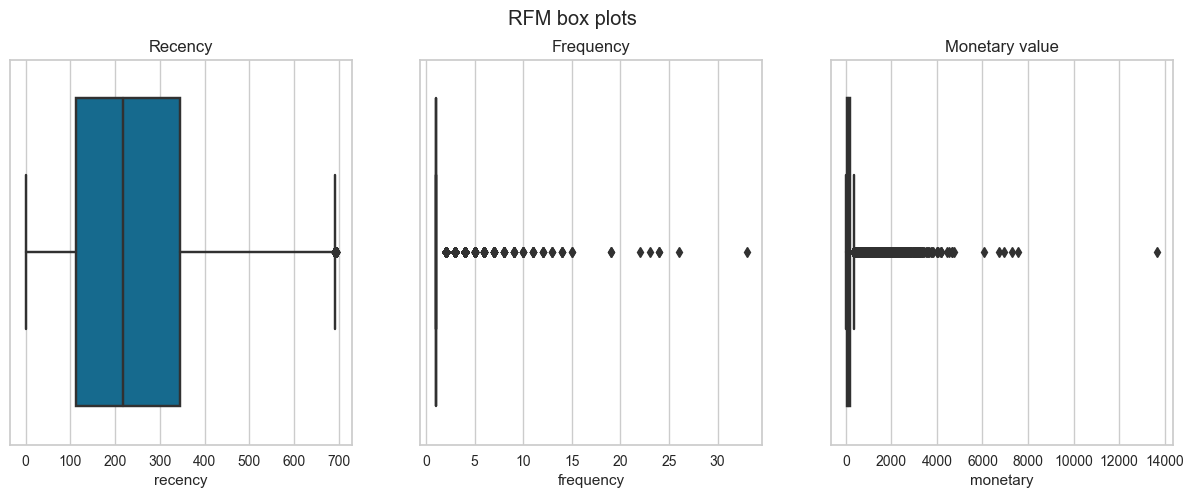

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("RFM box plots")

# Recency
sns.boxplot(ax=axes[0], data=rfm, x="recency")
axes[0].set_title("Recency")

# Frequency
sns.boxplot(ax=axes[1], data=rfm, x="frequency")
axes[1].set_title("Frequency")

# Monetary value
sns.boxplot(ax=axes[2], data=rfm, x="monetary")
axes[2].set_title("Monetary value")

plt.show()

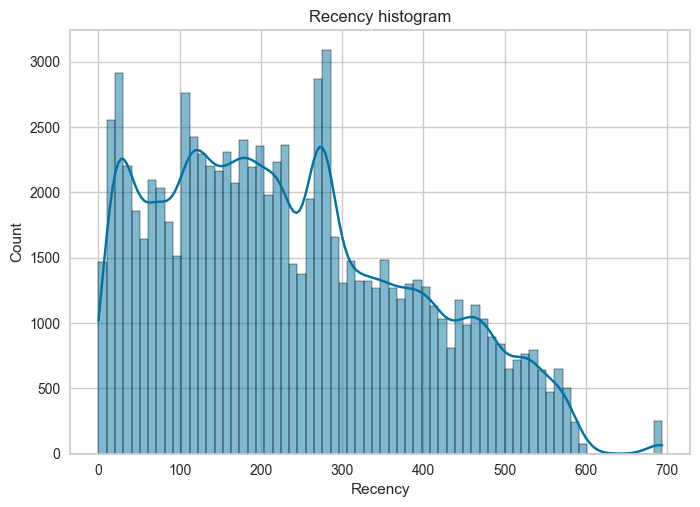

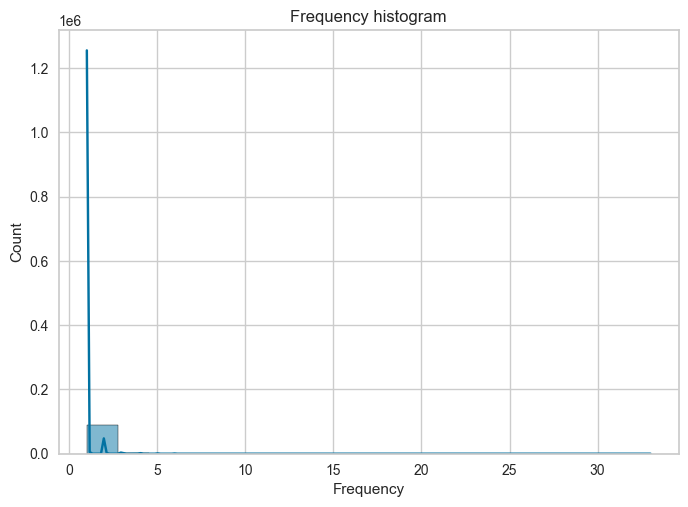

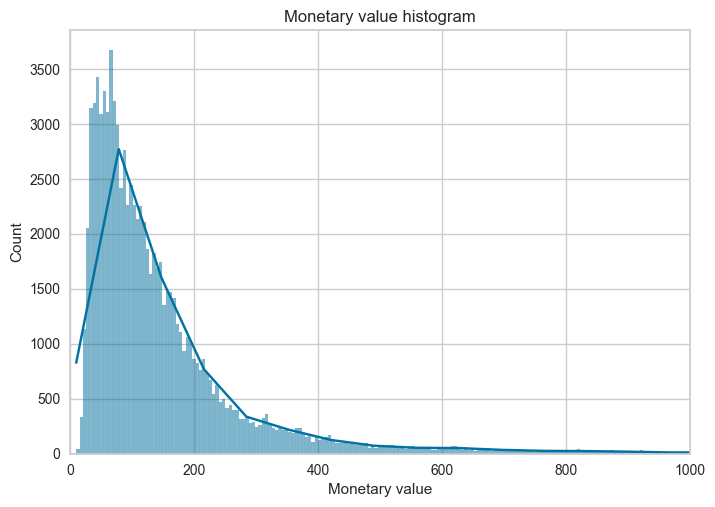

In [57]:
ax = sns.histplot(data=rfm, x="recency", kde=True)
ax.set(xlabel="Recency", title="Recency histogram")
plt.show()

ax = sns.histplot(data=rfm, x="frequency", kde=True)
ax.set(xlabel="Frequency", title="Frequency histogram")
plt.show()

ax = sns.histplot(data=rfm, x="monetary", kde=True)
ax.set(xlabel="Monetary value", title="Monetary value histogram", xlim=(0, 1000))
plt.show()

In [58]:
rfm["frequency"].describe()

count    91441.000000
mean         1.084535
std          0.477771
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         33.000000
Name: frequency, dtype: float64

In [59]:
rfm["monetary"].describe()

count    91441.000000
mean       165.752530
std        226.301747
min          9.590000
25%         63.100000
50%        107.780000
75%        183.530000
max      13664.080000
Name: monetary, dtype: float64

In [60]:
rfm["recency"].describe()

count    91441.000000
mean       236.084579
std        152.580973
min          0.000000
25%        113.000000
50%        217.000000
75%        344.000000
max        694.000000
Name: recency, dtype: float64

We can retreive some information from these plots and functions.

<b>Recency</b>
- The average client ordered 236 days ago

<b>Frequency</b>
- The frequency of orders is very low, most clients only pass one order via Olist, although there are a few outliers, with the maximum being at 75 orders
- Only approximately 3% of clients pass a second order

<b>Monetary value</b>
- Most clients order for an amount of 212 BRL
- The most ever spent by a client was 109312 BRL 

### RFM groups

Labels 1, 2, 3 refer to quantiles (0-33, 33-66, 66-100), for frequency the value is either 1 or 2.  

Main (123) customers are most recent, frequent and revenue generating, they are the most valuable.  
Gone (311, 312, 313) customers are customers who ordered once a long time ago.  
New (111, 112, 113) customers just joined and made their first order.  
Spenders (323, 213, 223) are customers who spent the most.  
Loyal (221, 222, 321, 322) are customers who have ordered more than once.  
Regular (121, 122, 211, 212) are average customers. 

In [61]:
rfm["R_score"] = pd.qcut(rfm["recency"], 3, labels=[1, 2, 3]).astype(str)
rfm["M_score"] = pd.qcut(rfm["monetary"], 3, labels=[1, 2, 3]).astype(str)
rfm["F_score"] = rfm["frequency"].apply(lambda x: "1" if x == 1 else "2")

rfm["rfm_score"] = rfm["R_score"] + rfm["F_score"] + rfm["M_score"]

In [62]:
def segment(x):
    if x == "123":
        return "Main"
    elif x in ["311", "312", "313"]:
        return "Gone"
    elif x in ["111", "112", "113"]:
        return "New"
    elif x in ["323", "213", "223"]:
        return "Spender"
    elif x in ["221", "222", "321", "322"]:
        return "Loyal"
    else:
        return "Regular"

In [63]:
rfm["segments"] = rfm["rfm_score"].apply(segment)
rfm["segments"].value_counts(normalize=True) * 100

New        31.436664
Gone       31.208101
Regular    22.202294
Spender    12.171783
Loyal       1.913802
Main        1.067355
Name: segments, dtype: float64

In [64]:
segment_analysis = rfm.groupby("segments").agg(
    RecencyMean=("recency", "mean"),
    FrequencyMean=("frequency", "mean"),
    MonetaryMean=("monetary", "mean"),
    GroupSize=("recency", "size"),
)
segment_analysis

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
segments,,,,
Gone,416.624838,1.000000,162.243839,28537
Loyal,328.438286,2.431429,85.588549,1750
Main,72.646516,2.359631,407.299980,976
New,74.029743,1.000000,164.148371,28746
Regular,213.574574,1.049897,79.180496,20302
Spender,232.602606,1.259209,328.228972,11130


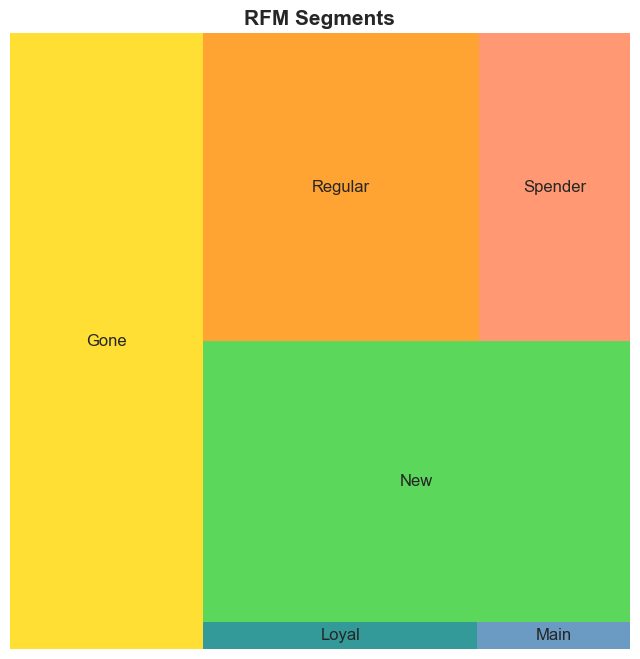

In [65]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(8, 8)
squarify.plot(
    sizes=segment_analysis["GroupSize"],
    label=segment_analysis.index,
    color=["gold", "teal", "steelblue", "limegreen", "darkorange", "coral"],
    alpha=0.8,
)
plt.title("RFM Segments", fontsize=15, fontweight="bold")
plt.axis("off")
plt.show()

### Merging df and RFM

In [66]:
df_rfm = rfm.merge(df, on=["customer_unique_id"])

In [67]:
# aggregating important variables

df_clients = df.groupby("customer_unique_id").agg(
    freight=("freight_value", "mean"),
    installments=("payment_installments", "mean"),
    review=("review_score", "mean"),
    sequential=("payment_sequential", "mean"),
    month=("order_month", "mean"),
)

In [68]:
df_rfm = df_clients.merge(df_rfm, on=["customer_unique_id"])

In [69]:
df_rfm.to_csv("data_rfm.csv")  # save data for simulation notebook

In [70]:
df_rfm = df_rfm[
    [
        "recency",
        "frequency",
        "monetary",
        "days_to_deliver",
        "freight",
        "installments",
        "review",
        "sequential",
        "month",
    ]
]

In [71]:
df_rfm.describe()

,recency,frequency,monetary,days_to_deliver,freight,installments,review,sequential,month
count,99171.000000,99171.000000,99171.000000,99171.000000,99171.000000,99171.000000,99171.000000,99171.000000,99171.000000
mean,237.088927,1.295006,173.517967,12.068074,20.218625,2.857610,4.155771,1.088473,6.036321
std,152.781376,1.411235,236.909857,9.465706,15.700075,2.651337,1.272247,0.543213,3.190990
min,0.000000,1.000000,9.590000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,113.000000,1.000000,64.130000,6.000000,13.370000,1.000000,4.000000,1.000000,3.000000
50%,218.000000,1.000000,111.400000,10.000000,16.460000,1.666667,5.000000,1.000000,6.000000
75%,346.000000,1.000000,191.580000,15.000000,21.310000,4.000000,5.000000,1.000000,8.000000
max,694.000000,33.000000,13664.080000,208.000000,409.680000,24.000000,5.000000,13.500000,12.000000


<AxesSubplot:>

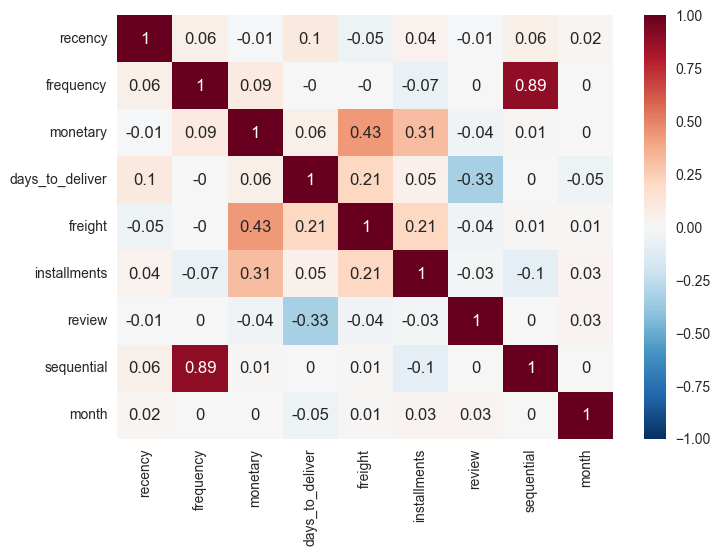

In [72]:
sns.heatmap(round(df_rfm.corr(), 2), cmap="RdBu_r", vmin=-1, vmax=1, annot=True)

There are some features with a high collinearity, so we can use that information to further remove some features. Also through iteration we notice some other features which are not as interesting as those chosen finally.

In [73]:
df_rfm = df_rfm[["recency", "frequency", "monetary", "review", "installments", "month"]]

<AxesSubplot:>

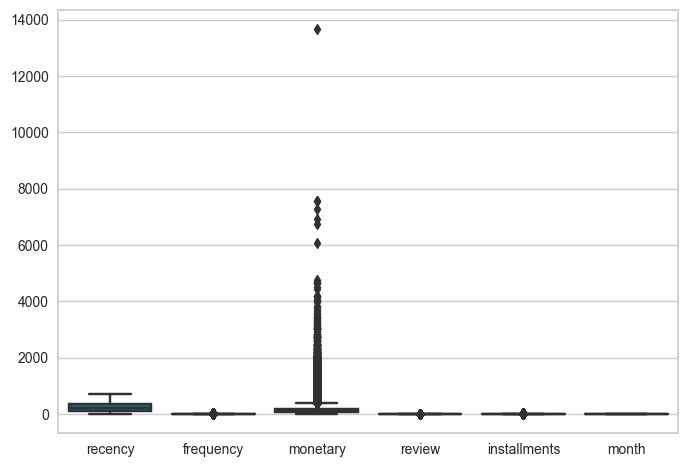

In [74]:
sns.boxplot(data=df_rfm)

In [75]:
# Remove zeros from data before log trans
df_rfm[df_rfm.columns[1:]] = df_rfm[df_rfm.columns[1:]].applymap(
    lambda x: 1 if x == 0 else x
)

In [76]:
# Running K-Means algo to cluster our data
# Let's check if data is skewed first
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title("Distribution of " + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

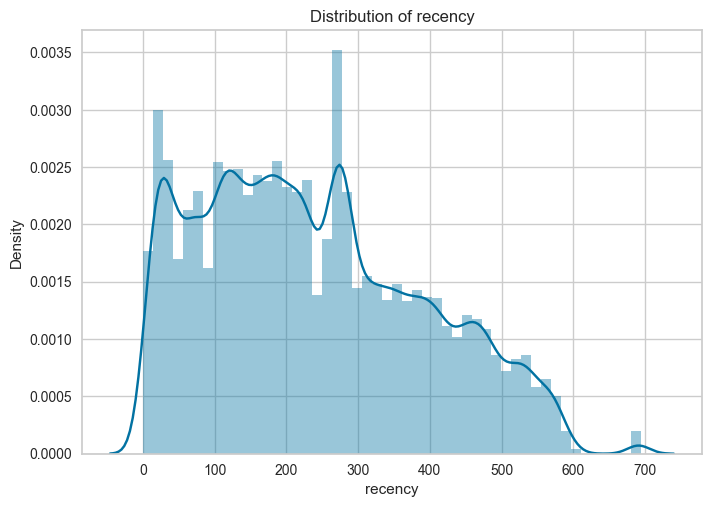

recency's: Skew: 0.44396110526292426, : SkewtestResult(statistic=54.588437835972485, pvalue=0.0)


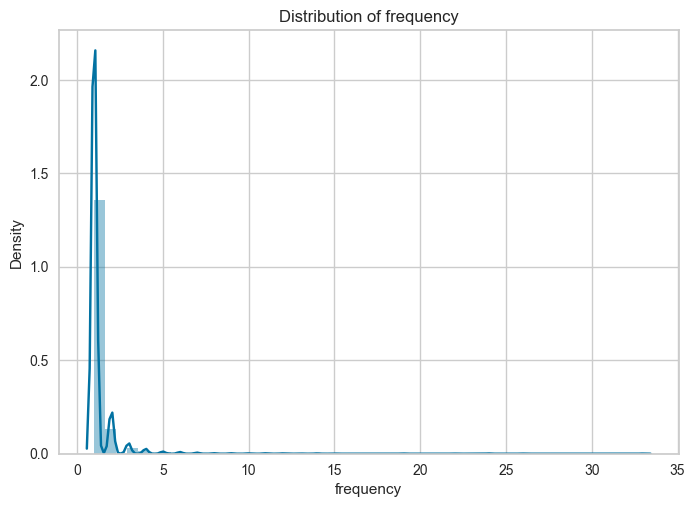

frequency's: Skew: 11.735248081132594, : SkewtestResult(statistic=352.7256880235544, pvalue=0.0)


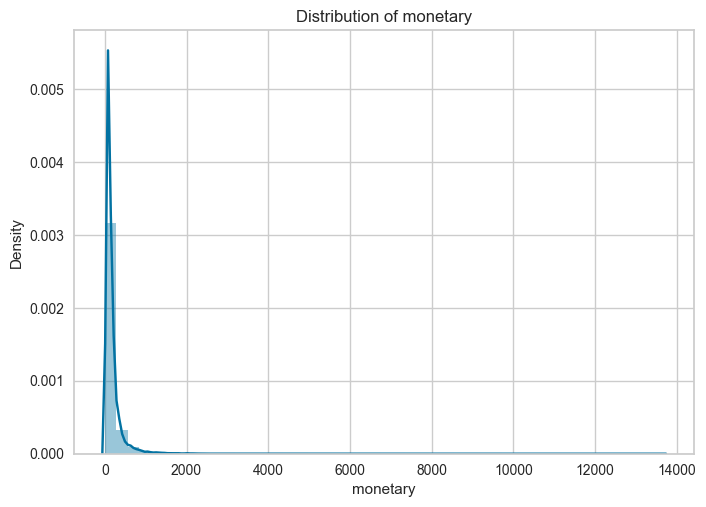

monetary's: Skew: 8.420808636164066, : SkewtestResult(statistic=317.99911895230593, pvalue=0.0)


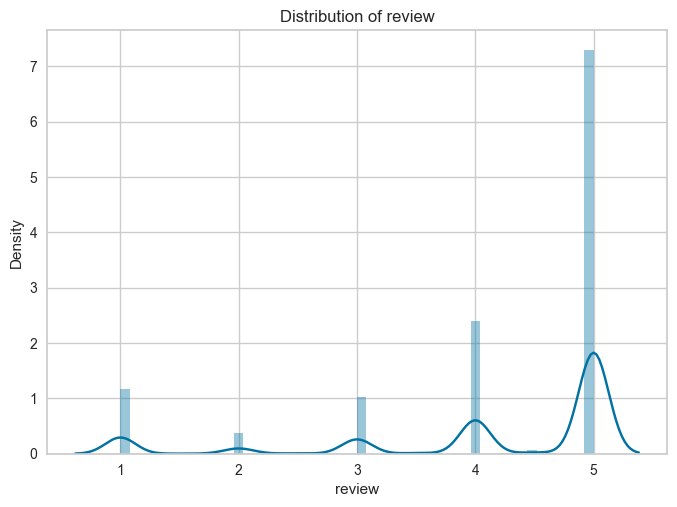

review's: Skew: -1.479930541423859, : SkewtestResult(statistic=-142.41162282877264, pvalue=0.0)


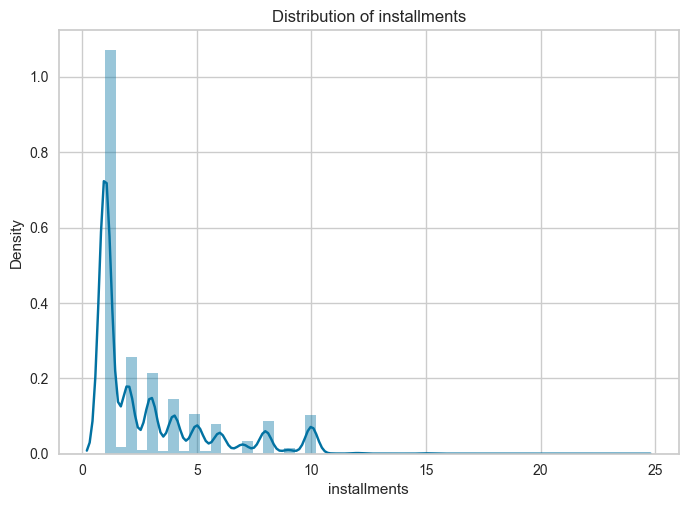

installments's: Skew: 1.6392831910527927, : SkewtestResult(statistic=151.9196213205109, pvalue=0.0)


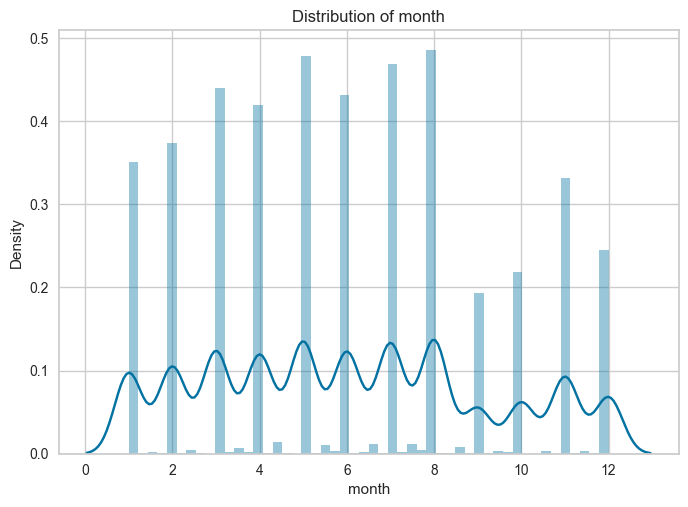

month's: Skew: 0.2047866942466105, : SkewtestResult(statistic=26.061565027165884, pvalue=9.948862373603745e-150)


In [77]:
for col in df_rfm.columns[0:]:
    check_skew(df_rfm, col)

We check our columns for skewness and perform a log transform on columns whose skewness value is bigger than 1 or lower than -1.  

In [78]:
df_rfm_log = df_rfm.copy()

In [79]:
df_rfm_log["frequency"] = np.log10(df_rfm_log["frequency"])
df_rfm_log["monetary"] = np.log10(df_rfm_log["monetary"])

<AxesSubplot:>

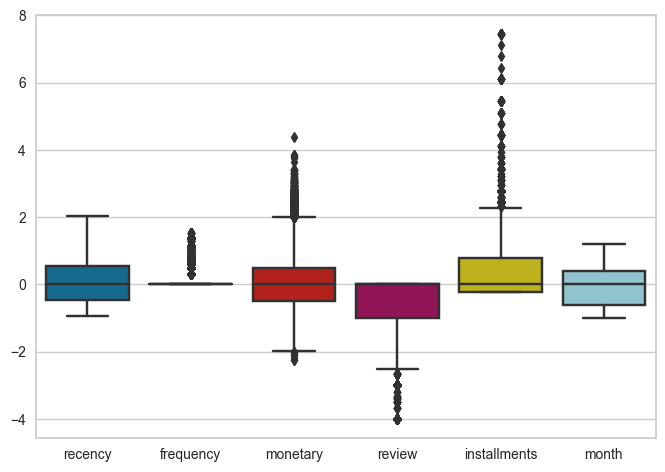

In [298]:
scaler = RobustScaler()

df_scaled = scaler.fit_transform(df_rfm_log)
df_scaled = pd.DataFrame(df_scaled, index=df_rfm_log.index, columns=df_rfm_log.columns)

sns.boxplot(data=df_scaled)

<AxesSubplot:>

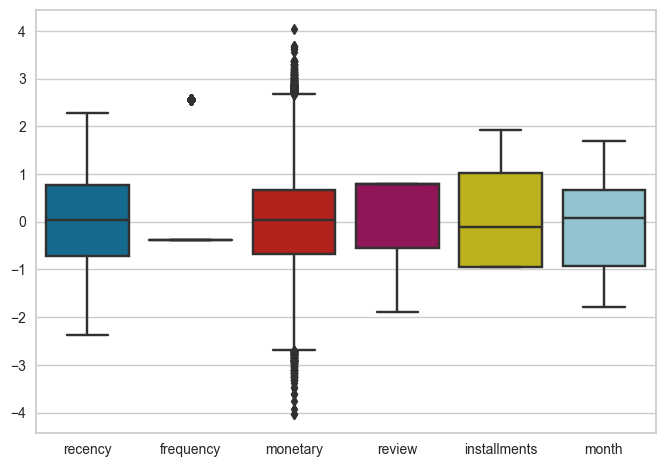

In [306]:
scaler = PowerTransformer()

df_scaled = scaler.fit_transform(df_rfm_log)
df_scaled = pd.DataFrame(df_scaled, index=df_rfm_log.index, columns=df_rfm_log.columns)

sns.boxplot(data=df_scaled)

<AxesSubplot:>

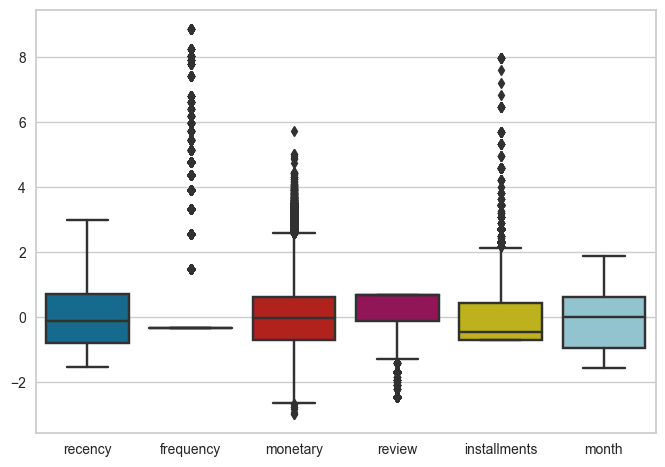

In [80]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_rfm_log)
df_scaled = pd.DataFrame(df_scaled, index=df_rfm_log.index, columns=df_rfm_log.columns)

sns.boxplot(data=df_scaled)

### KMeans choosing the amount of clusters

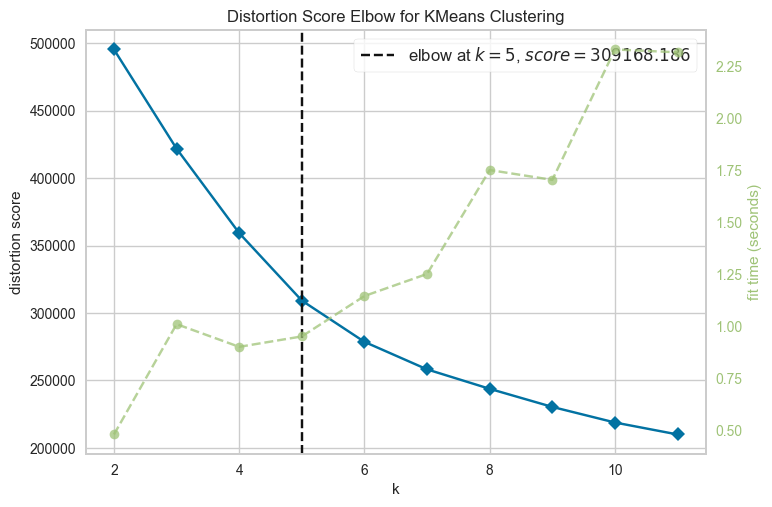

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
visualizer = KElbowVisualizer(
    KMeans(), k=(2, 12), metric="distortion", init="k-means++"
)

visualizer.fit(df_scaled)
visualizer.show()

In [83]:
# Create a k-means clustering model
kmeans = KMeans(init="k-means++", n_clusters=5, random_state=22)

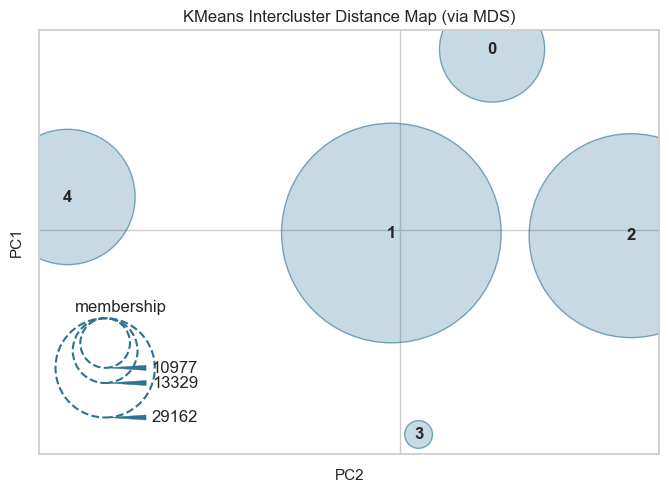

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=5, random_state=22),
                     random_state=22)

In [84]:
intercluster_distance(kmeans, df_scaled, random_state=22)

RobustScaler() gives a distortion score of 171552, with 4 clusters which overlap.  

StandardScaler() gives a distortion score of 309168, with 5 cluster which do NOT overlap.  

PowerTransformer() gives a distortion score of 319700 with 5 clusters which overlap.  

Let's try removing the feature "month" to see if it improves our distortion score or the overlap problem.

In [310]:
df_rfm_log_nm = df_rfm_log.drop(columns=["month"])

<AxesSubplot:>

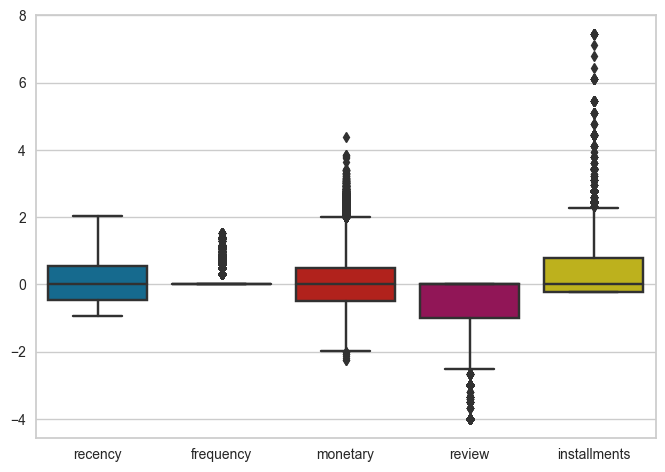

In [321]:
scaler = RobustScaler()

df_scaled = scaler.fit_transform(df_rfm_log_nm)
df_scaled = pd.DataFrame(
    df_scaled, index=df_rfm_log_nm.index, columns=df_rfm_log_nm.columns
)

sns.boxplot(data=df_scaled)

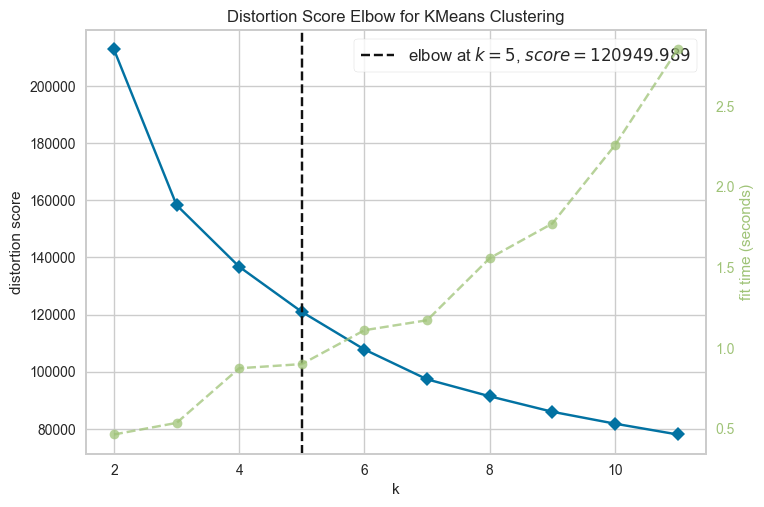

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [322]:
visualizer = KElbowVisualizer(
    KMeans(), k=(2, 12), metric="distortion", init="k-means++"
)

visualizer.fit(df_scaled)
visualizer.show()

In [323]:
# Create a k-means clustering model
kmeans = KMeans(init="k-means++", n_clusters=5)

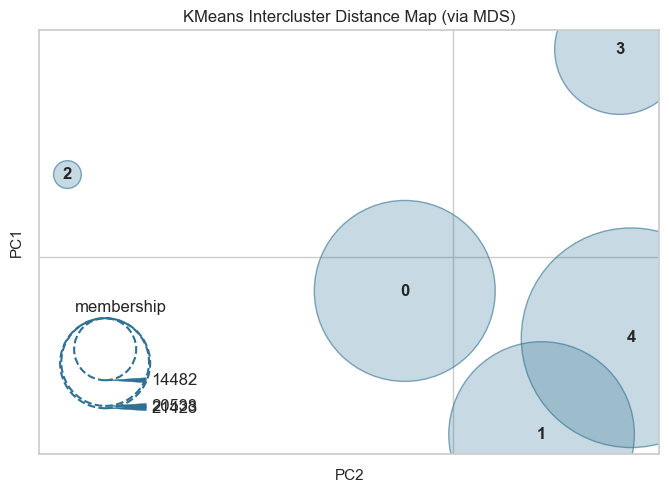

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=5))

In [324]:
intercluster_distance(kmeans, df_scaled)

RobustScaler() gives a distortion score of 120949, with 5 clusters which overlap.  

StandardScaler() gives a distortion score of 227156, with 5 cluster which overlap.  

PowerTransformer() gives a distortion score of 229413 with 5 clusters which overlap.  

Removing "month" did not fix the overlapping problem. We go back to StandardScaler with all of our features.

<AxesSubplot:>

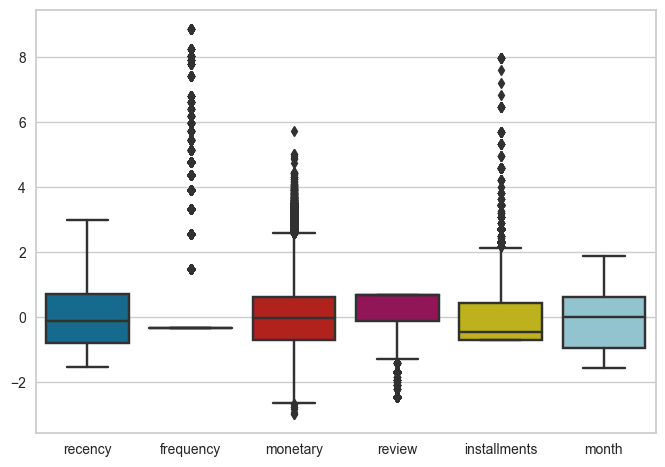

In [85]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_rfm_log)
df_scaled = pd.DataFrame(df_scaled, index=df_rfm_log.index, columns=df_rfm_log.columns)

sns.boxplot(data=df_scaled)

In [348]:
kmeans_silhouette = silhouette_score(df_scaled, kmeans.labels_).round(2)

kmeans_silhouette

0.26

### Checking the performance of a second model: DBSCAN

In [346]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

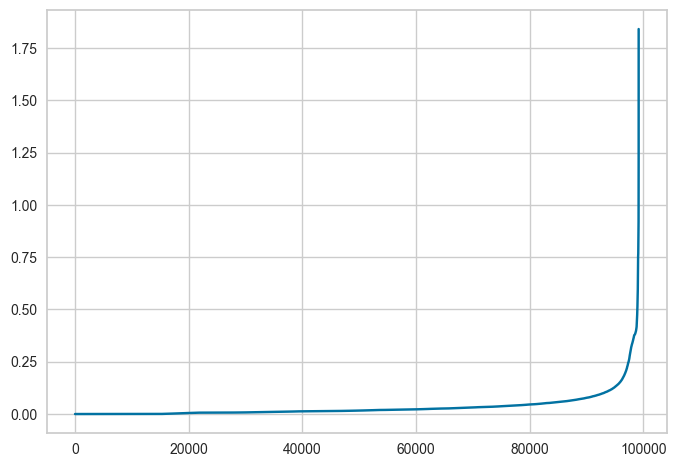

In [347]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

In [349]:
# the optimal epsilon value, the hyperparameter taken in by DBSCAN, is approximately 0.3

dbscan = DBSCAN(eps=0.3)
dbscan.fit(df_scaled)
labels = dbscan.labels_

In [350]:
# # Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1506
Estimated number of noise points: 10252


In [351]:
dbscan_silhouette = silhouette_score(df_scaled, labels).round(2)

dbscan_silhouette

-0.1

We can confirm with the estimated number of clusters and the silhouette score which is very low that KMeans is much more adapted for this clustering problem than DBSCAN.

### Dimensional reduction to visualize the clusters

In [86]:
# Fit the data to the model
kmeans.fit(df_scaled)

# Determine which clusters each data point belongs to:
clusters = kmeans.predict(df_scaled)
# Add cluster number to the original data
df_scaled_clustered = pd.DataFrame(
    df_scaled, columns=df_scaled.columns, index=df_scaled.index
)
df_scaled_clustered["cluster"] = clusters
# df_scaled = df_scaled.drop(columns=["cluster"])

df_scaled_clustered.head()

,recency,frequency,monetary,review,installments,month,cluster
0,-0.825294,-0.341794,0.243023,0.663576,1.939561,-0.324766,4
1,-0.805658,-0.341794,-1.739661,-0.122439,-0.700647,-0.324766,1
2,1.956473,-0.341794,-0.354828,-0.908454,1.939561,-0.951534,4
3,0.542681,-0.341794,-1.172474,-0.122439,0.430871,1.242153,2
4,0.326685,-0.341794,0.636042,0.663576,1.185216,1.555537,4


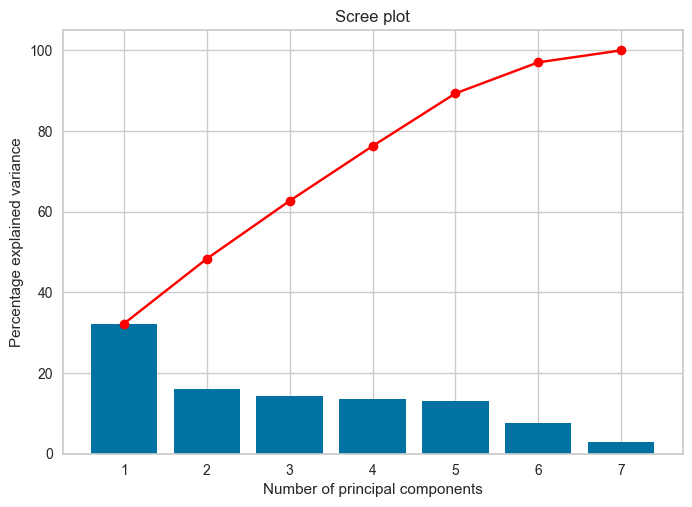

In [87]:
# Select the number of principal components we will return
num_components = df_scaled.shape[1]

# Create the PCA model
pca = PCA(n_components=num_components)

# Fit the model with the standardised data
pca.fit(df_scaled)
display_scree_plot(pca)

In [88]:
pca = PCA(n_components=6)
pca.fit(df_scaled)
df_reduced = pca.transform(df_scaled)
df_reduced = pd.DataFrame(
    df_reduced,
    index=df_scaled.index,
    columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"],
)
df_reduced["cluster"] = clusters
df_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,cluster
0,2.456093,0.443506,-1.103178,-1.022776,-0.500424,-1.096000,4
1,-1.825302,-0.536031,-0.285520,-0.405718,-0.085836,-1.024875,1
2,2.315292,0.554019,-0.168696,1.858844,-1.788304,-1.375061,4
3,0.054702,-0.741317,-0.877211,1.077517,0.607866,-0.833012,2
4,2.693174,-0.463429,-1.225669,0.360826,0.775827,-0.024935,4


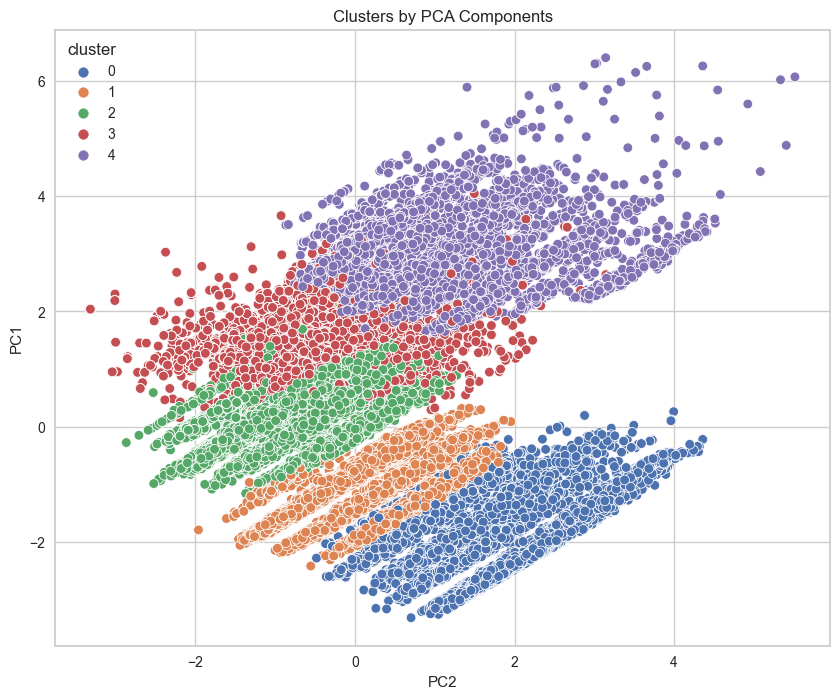

In [89]:
x_axis = df_reduced["PC2"]
y_axis = df_reduced["PC1"]
plt.figure(figsize=(10, 8))
sns.scatterplot(x_axis, y_axis, hue=df_reduced["cluster"], palette="deep")
plt.title("Clusters by PCA Components")
plt.show()

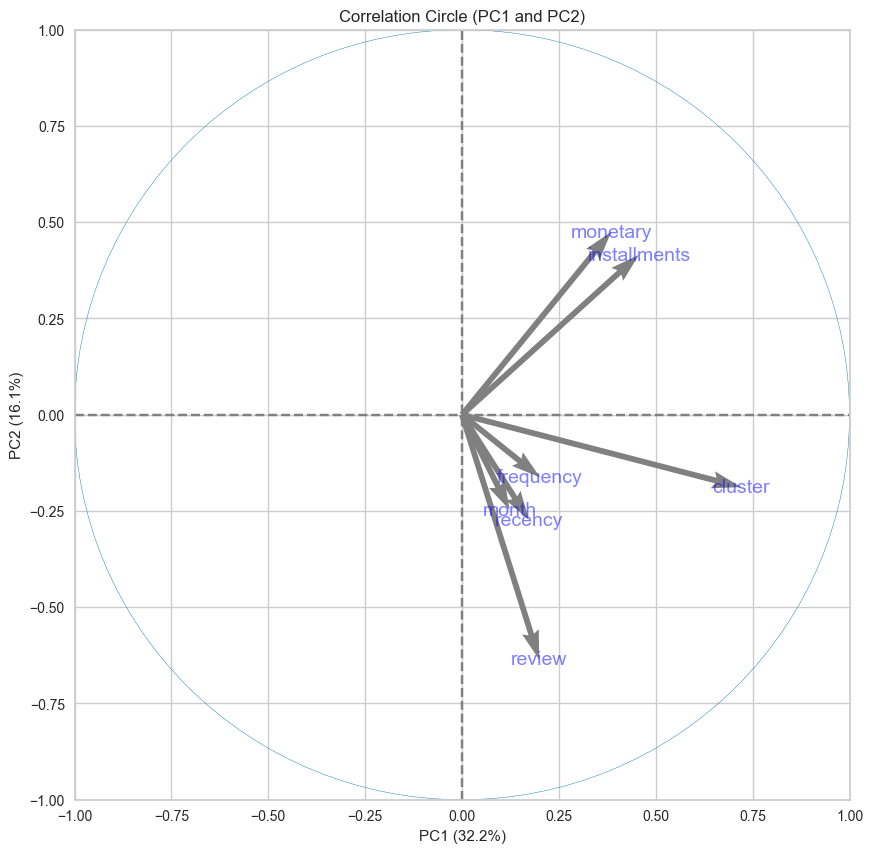

In [90]:
# Generate a correlation circle
pcs = pca.components_
display_circles(pcs, 6, pca, [(0, 1)], labels=df_scaled.columns)

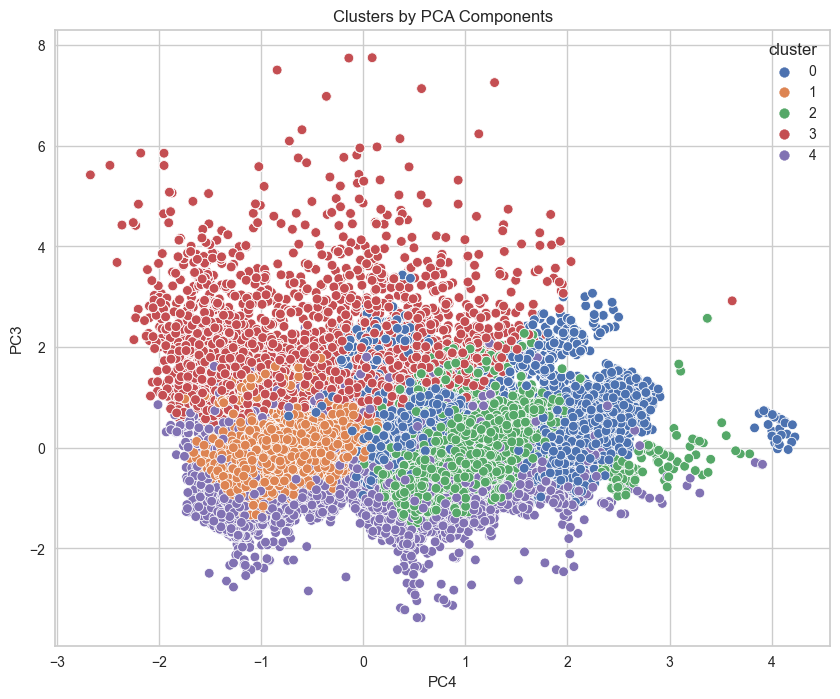

In [357]:
x_axis = df_reduced["PC4"]
y_axis = df_reduced["PC3"]
plt.figure(figsize=(10, 8))
sns.scatterplot(x_axis, y_axis, hue=df_reduced["cluster"], palette="deep")
plt.title("Clusters by PCA Components")
plt.show()

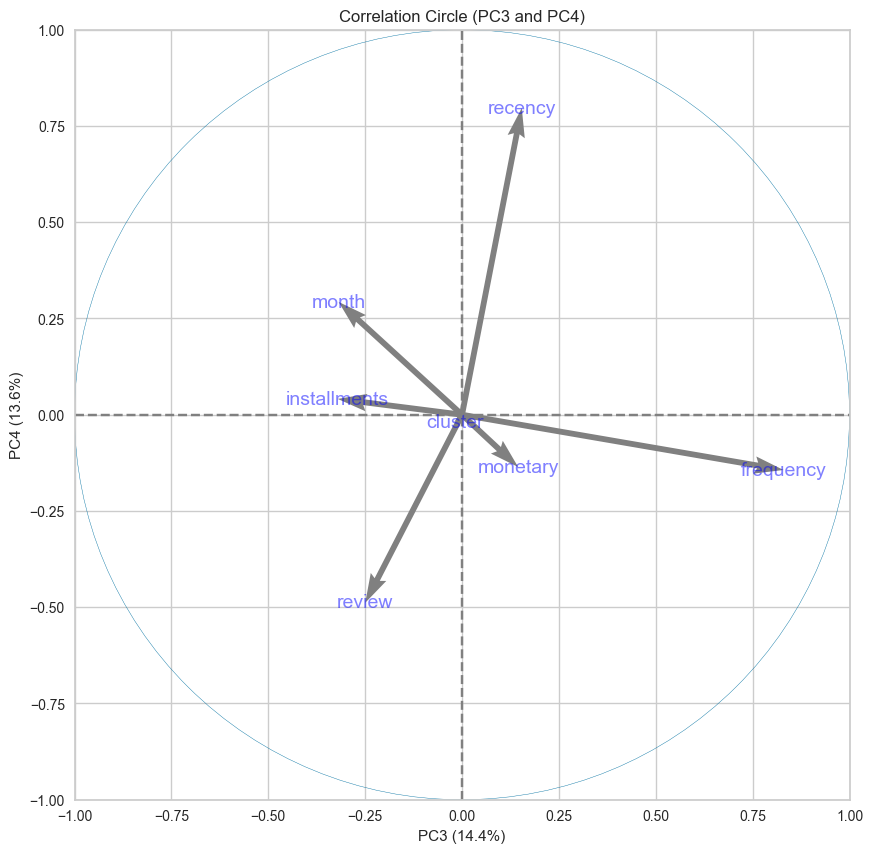

In [358]:
# Generate a correlation circle
pcs = pca.components_
display_circles(pcs, 6, pca, [(2, 3)], labels=df_scaled.columns)

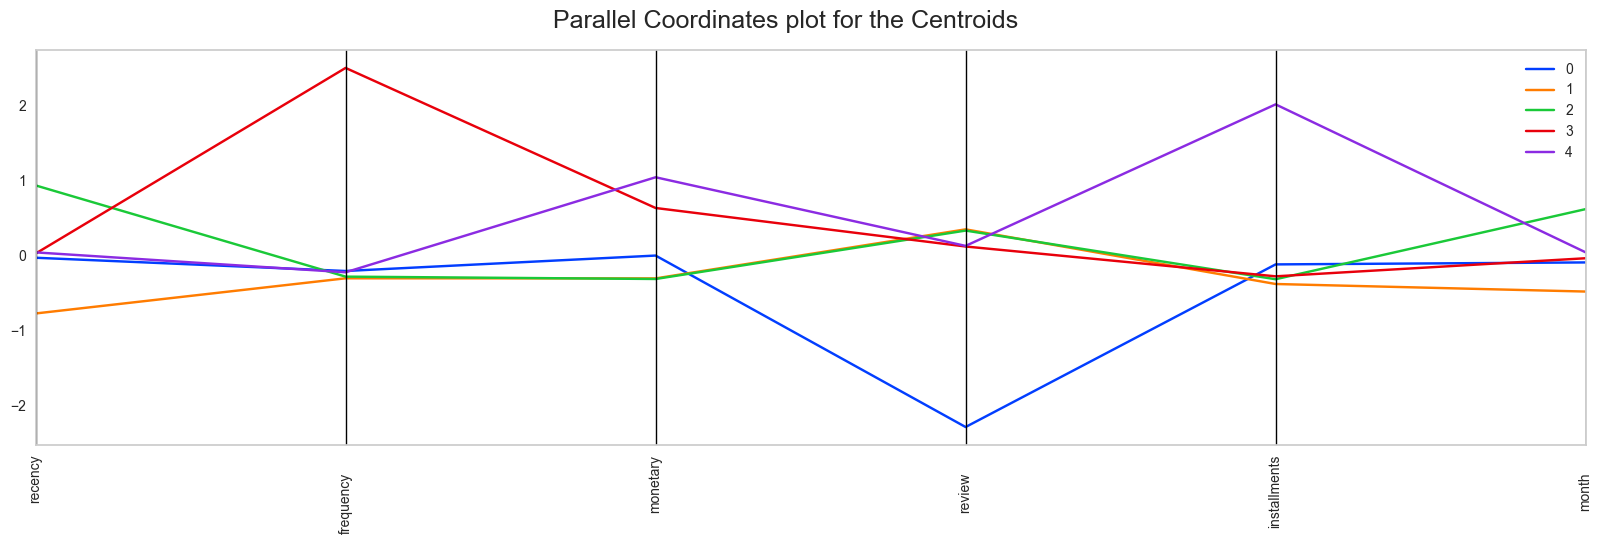

In [359]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_log.columns)
centroids["cluster"] = centroids.index

display_parallel_coordinates_centroids(centroids, centroids.shape[1])
plt.xticks(rotation=90)
plt.show()

In [362]:
clusters = df_scaled_clustered["cluster"]
df_rfm["cluster"] = clusters

In [363]:
print(
    "Cluster 0: "
    + str(
        round(
            df_scaled_clustered[df_scaled_clustered["cluster"] == 0].shape[0]
            / df_scaled_clustered.shape[0]
            * 100,
            2,
        )
    )
    + " %"
)
print(
    "Cluster 1: "
    + str(
        round(
            df_scaled_clustered[df_scaled_clustered["cluster"] == 1].shape[0]
            / df_scaled_clustered.shape[0]
            * 100,
            2,
        )
    )
    + " %"
)
print(
    "Cluster 2: "
    + str(
        round(
            df_scaled_clustered[df_scaled_clustered["cluster"] == 2].shape[0]
            / df_scaled_clustered.shape[0]
            * 100,
            2,
        )
    )
    + " %"
)
print(
    "Cluster 3: "
    + str(
        round(
            df_scaled_clustered[df_scaled_clustered["cluster"] == 3].shape[0]
            / df_scaled_clustered.shape[0]
            * 100,
            2,
        )
    )
    + " %"
)
print(
    "Cluster 4: "
    + str(
        round(
            df_scaled_clustered[df_scaled_clustered["cluster"] == 4].shape[0]
            / df_scaled_clustered.shape[0]
            * 100,
            2,
        )
    )
    + " %"
)

Cluster 0: 11.08 %
Cluster 1: 36.26 %
Cluster 2: 29.41 %
Cluster 3: 9.82 %
Cluster 4: 13.44 %


<b>Cluster 0 (11%) last bought 8 months ago, once, spent 165 on average, left a bad review (1/5), paid in 2.5 installments on average, buys on average in may/june</b>  

The unsatisfied buyer

In [364]:
df_rfm[df_rfm["cluster"] == 0].mean()

recency         232.656654
frequency         1.075915
monetary        165.458716
review            1.253595
installments      2.544875
month             5.747042
cluster           0.000000
dtype: float64

<b>Cluster 1 (36%) last bought 4 months ago, once, spent 116 on average, left a good review (4.6/5), paid in 2 installments on average, buys on average in april/may</b>  

The recent buyer

In [365]:
df_rfm[df_rfm["cluster"] == 1].mean()

recency         119.420892
frequency         1.021414
monetary        116.579930
review            4.598354
installments      1.854493
month             4.507773
cluster           1.000000
dtype: float64

<b>Cluster 2 (29%) last bought a year ago, once, spent 117 on average, left a good review (4.6/5), paid in 2 installments on average, buys on average in august</b>  

The average buyer

In [366]:
df_rfm[df_rfm["cluster"] == 2].mean()

recency         379.568700
frequency         1.033536
monetary        117.268180
review            4.577821
installments      2.022186
month             8.005452
cluster           2.000000
dtype: float64

<b>Cluster 3 (10%) last bought 8 months ago, three and a half times, spent 273 on average, left a good review (4/5), paid in 2 installments on average, buys on average in may/june</b>  

In [367]:
df_rfm[df_rfm["cluster"] == 3].mean()

recency         241.100000
frequency         3.646612
monetary        273.093094
review            4.308624
installments      2.124435
month             5.923614
cluster           3.000000
dtype: float64

<b>Cluster 4 (13%) last bought 8 months ago, once, spent 384 on average, left a good review (4/5), paid in 8 installments on average, buys on average in june</b>  

In [368]:
df_rfm[df_rfm["cluster"] == 4].mean()

recency         243.503715
frequency         1.067242
monetary        384.130406
review            4.318799
installments      8.186792
month             6.172308
cluster           4.000000
dtype: float64